# Baseline analysis of ELL pyramidal cells in *A. leptorhynchus*

Plan: 
- Plot the baseline, mark spikes
- ISI histogram
- ISI correlations
- Spike bursts vs single spikes

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import rlxnix as rlx

# load data
d = rlx.Dataset("../data/2022-10-20-ab-invivo-1.nix")

# extract baseline
bl = d["BaselineActivity_2"]

# extract voltage and time
spike_times = bl.spikes()
v, t = bl.membrane_voltage()

bl.baseline_rate

16.553565875875695

## Baseline plot

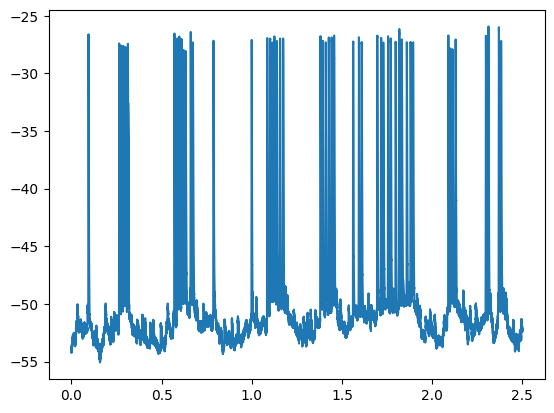

In [8]:
fig, ax = plt.subplots()
ax.plot(t[:100000], v[:100000])
#ax.scatter(spike_times, np.ones_like(spike_times) * np.max(v), marker="|")
plt.show()

## Interspike-interval histograms

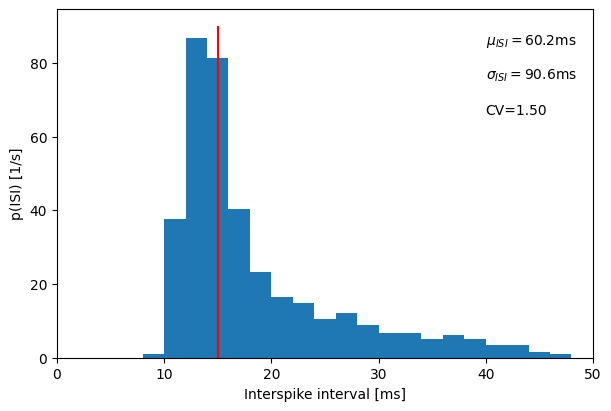

In [18]:
def isis(spike_times):
    """
    Compute interspike intervals of spike times per recording trial.

    Parameters
    ----------
    spike_times : array-like of arrays
        A list/array of trials containing spike times

    Returns
    -------
    isiarray : array of float
        Interspike intervals
    """    

    isiarray = []
    for times in spike_times:
        difftimes = np.diff(times)
        isiarray.append(difftimes)
    
    return isiarray

def isih(isis, bin_width):
    """
    isih computes the probability density function of the interspike intervals.

    Parameters
    ----------
    isis : bool
        _description_
    bin_width : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """    

    bins = np.arange(0.0, np.max(isis) + bin_width, bin_width)
    counts, edges = np.histogram(isis, bins)
    centers = edges[:-1] + 0.5*bin_width
    pdf = counts / np.sum(counts) / bin_width
    
    return pdf, centers


def plot_isih(ax, isis, binwidth):
    """
    Plot the interspike interval histogram.

    Parameters
    ----------
    ax : matplotlib axis
    isis : 1d-array of floats
        The interspike intervals
    binwidth : float
        Bin width to be used for the histogram
    """    

    pdf, centers = isih(isis, binwidth)
    
    # compute histogram
    misi = np.mean(isis)
    
    # basic statistics
    sdisi = np.std(isis)
    cv = sdisi / misi
    ax.bar(centers*1000, pdf, width=binwidth*1000) # plot histogram with ISIs in ms
    
    ax.set_xlabel('Interspike interval [ms]')
    ax.set_ylabel('p(ISI) [1/s]')
    
    ax.text(0.8, 0.9, rf'$\mu_{{ISI}}={misi*1000:.1f}$ms', transform=ax.transAxes)
    ax.text(0.8, 0.8, rf'$\sigma_{{ISI}}={sdisi*1000:.1f}$ms',transform=ax.transAxes)
    ax.text(0.8, 0.7, rf'CV={cv:.2f}', transform=ax.transAxes)


isi = isis([spike_times])
bin_width = 0.002
pdf, centers = isih(isi, bin_width)

fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
plot_isih(ax, isi, bin_width)
ax.set_xlim(0, 50)
ax.vlines(15, 0, 90, color='red')
plt.show()

We see that:
- Short intervals (approx. 25 ms) are most common
- The CV (above 1) is typical for irregular firing neurons with a relatively high firing rate. Small intervals are seperated by very large intervals.

## Plot interspike interval correlations

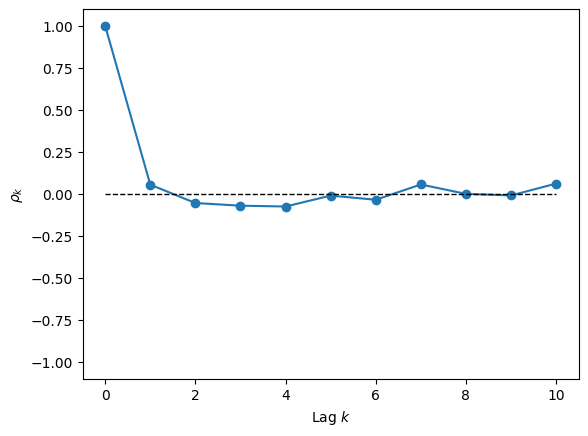

In [10]:
def isi_serialcorr(isis, max_lag=10):
    """
    Serial correlations of interspike intervals

    Parameters
    ----------
    isis : 1d-array of floats
        Interspike intervals
    max_lag : int, optional
        Maximum lag, by default 10

    Returns
    -------
    isicorr : array of floats
        Interspike interval correlations
    lags : array of integers
        Lags of interval correlations
    """    
    
    lags = np.arange(max_lag + 1)
    isicorr = np.zeros(len(lags))
    nisis = len(isis)
    for k in range(len(lags)): # for each lag
        lag = lags[k]
        if nisis > lag + 10:
        # ensure "enough" data
            isicorr[k] = np.corrcoef(isis[:nisis-lag], isis[lag:])[0,1]
    return isicorr, lags

isicorr, lags = isi_serialcorr(isi[0], max_lag=10)

fig, ax = plt.subplots()
ax.plot(lags, isicorr, '-o')
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Lag $k$')
ax.set_ylabel(r'$\rho_k$') # r-string: no need to escape backslash
ax.plot(lags, np.zeros_like(lags), lw = 1, linestyle = 'dashed', color = 'black')
plt.show()


## Spike bursts vs single spikes

Plan:
- Bandpass filter to cancel slow changes in the membrane potential and high frequency noise
- Threshold spikes and calculate mean spike width
- Determine that spikes are in bursts if they are max. 2x spike width apart. All others are singular spikes.

<function matplotlib.pyplot.show(close=None, block=None)>

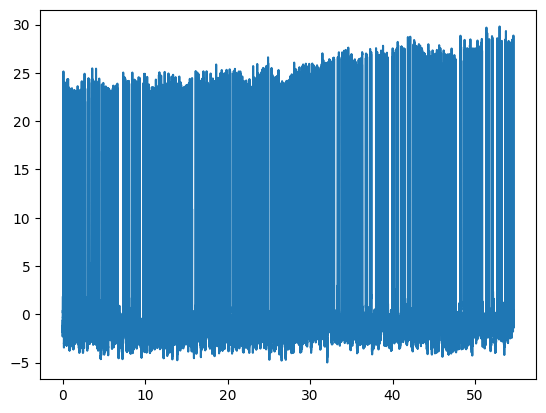

In [97]:
from scipy.signal import butter, sosfiltfilt

def bandpass_filter(data, rate, flow, fhigh, order=1):
    sos = butter(order, [flow, fhigh], btype="band", fs=rate, output="sos")
    y = sosfiltfilt(sos, data)
    return y

rate = 1 / (t[1]-t[0])  # in Hz
nqst = rate/2           # Niquist frequency 
v_filt = bandpass_filter(v, rate, 0.2, nqst*0.99)

plt.plot(t[:], v_filt[:])
plt.show